In [1]:
import numpy as np
from scipy.optimize import curve_fit
import pylab
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import scipy.stats
from sklearn import metrics
import tensorflow as tf
import seaborn as sns


In [2]:
import warnings
warnings.filterwarnings('ignore')

**Data Cleaning**

In [4]:
listings = pd.read_csv("listings.csv")

In [5]:
review = pd.read_csv("reviews_2.csv")

In [6]:
listings.drop(columns=['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'amenities', 'calendar_updated', 'has_availability', 'calendar_last_scraped', 'first_review',
       'last_review', 'license', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms'
       ], inplace=True)

listings.drop(columns=['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','reviews_per_month','bathrooms'], inplace=True)
listings.dropna(inplace=True)
listings.isnull().sum()

neighbourhood                   0
neighbourhood_cleansed          0
neighbourhood_group_cleansed    0
latitude                        0
longitude                       0
property_type                   0
room_type                       0
accommodates                    0
bathrooms_text                  0
bedrooms                        0
beds                            0
price                           0
minimum_nights                  0
maximum_nights                  0
minimum_minimum_nights          0
maximum_minimum_nights          0
minimum_maximum_nights          0
maximum_maximum_nights          0
minimum_nights_avg_ntm          0
maximum_nights_avg_ntm          0
availability_30                 0
availability_60                 0
availability_90                 0
availability_365                0
number_of_reviews               0
number_of_reviews_ltm           0
number_of_reviews_l30d          0
dtype: int64

In [7]:
def convert(text):
    if text[0].isnumeric():
        return float(text.split(" ")[0])
    else:
        return 1.0    #"shared"
listings["bathrooms"] = listings["bathrooms_text"].apply(convert)
listings.drop(columns='bathrooms_text', inplace=True)

In [8]:
#cast price into float
listings["price"] = listings["price"].str[1:].str.replace(",","").astype("float")
listings = listings[listings.price < 1000]

listings_clean = listings.copy()
listings_clean.reset_index(inplace=True)
listings_clean.drop(columns='index', inplace=True)


In [9]:
listings_clean = pd.get_dummies(data=listings_clean, prefix=['nbh', 'pt', 'rt'], columns=['neighbourhood_cleansed', 'property_type', 'room_type'], drop_first=True)
listings_clean



,neighbourhood,neighbourhood_group_cleansed,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,...,pt_Shared room in guesthouse,pt_Shared room in home,pt_Shared room in loft,pt_Shared room in rental unit,pt_Shared room in serviced apartment,pt_Shared room in townhouse,pt_Tiny home,rt_Hotel room,rt_Private room,rt_Shared room
0,"The Bronx, New York, United States",Bronx,40.903260,-73.907090,3,2.0,2.0,125.0,3,21,...,0,0,0,0,0,0,0,0,0,0
1,"Queens, New York, United States",Queens,40.763500,-73.826080,3,1.0,1.0,63.0,2,365,...,0,0,0,0,0,0,0,0,1,0
2,"RIVERDALE, New York, United States",Bronx,40.882320,-73.906210,4,2.0,2.0,115.0,30,1125,...,0,0,0,0,0,0,0,0,0,0
3,"Queens, New York, United States",Queens,40.709585,-73.746119,4,3.0,5.0,179.0,1,1125,...,0,0,0,0,0,0,0,0,0,0
4,"Queens, New York, United States",Queens,40.596000,-73.771140,6,2.0,3.0,380.0,1,1125,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22074,"Brooklyn, New York, United States",Brooklyn,40.698330,-73.932630,1,1.0,1.0,50.0,30,31,...,0,0,0,0,0,0,0,0,1,0
22075,"Brooklyn, New York, United States",Brooklyn,40.675660,-73.965490,2,1.0,1.0,74.0,30,1125,...,0,0,0,0,0,0,0,0,1,0
22076,"Staten Island, New York, United States",Staten Island,40.579550,-74.110330,1,1.0,1.0,33.0,30,1125,...,0,0,0,0,0,0,0,0,1,0
22077,"New York, United States",Manhattan,40.778103,-73.985179,12,4.0,9.0,857.0,4,365,...,0,0,0,0,0,0,0,0,0,0


## Multi Linear Regression(Lasso, Ridge)

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [109]:
df = listings_clean
X = df.drop(['price',"neighbourhood","neighbourhood_group_cleansed","latitude","longitude"], axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [110]:
alphas = np.logspace(-2,2,10)

best_lasso_score = float('inf')
best_lasso_model = None
best_ridge_score = float('inf')
best_ridge_model = None
lasso_scores = []
ridge_scores = []
lasso_alpha = float('inf')
ridge_alpha = float('inf')


for alpha in alphas:
    
    lasso = Lasso(alpha=alpha)
    ridge = Ridge(alpha=alpha)

    lasso.fit(X_train, y_train)
    ridge.fit(X_train, y_train)

    y_pred_lasso = lasso.predict(X_test)
    y_pred_ridge = ridge.predict(X_test)

    lasso_score = mean_absolute_error(y_test, y_pred_lasso)
    ridge_score = mean_absolute_error(y_test, y_pred_ridge)
    
    lasso_scores.append(lasso_score)
    ridge_scores.append(ridge_score)

    if lasso_score < best_lasso_score:
        lasso_alpha = alpha
        best_lasso_score = lasso_score
        best_lasso_model = lasso

    if ridge_score < best_ridge_score:
        ridge_alpha = alpha
        best_ridge_score = ridge_score
        best_ridge_model = ridge

In [111]:
print("Best Lasso score:", best_lasso_score)
print("Best Ridge score:", best_ridge_score)
print("Best Lasso alpha:", lasso_alpha)
print("Best Ridge alpha:", ridge_alpha)

Best Lasso score: 73.25254009934301
Best Ridge score: 73.42215889764748
Best Lasso alpha: 0.0774263682681127
Best Ridge alpha: 12.915496650148826


In [115]:
lasso = Lasso(alpha=lasso_alpha)
lasso.fit(X_train, y_train)

coefficients = lasso.coef_
feature_names = X_train.columns

coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
coef_df = coef_df[coef_df['coefficient'] != 0]

In [116]:
df_sorted = coef_df.iloc[abs(coef_df['coefficient']).argsort()]

In [120]:
df_sorted.tail(8)

,feature,coefficient
193,nbh_SoHo,127.389362
223,nbh_West Village,132.229290
206,nbh_Theater District,135.814636
243,pt_Entire home/apt,136.290972
280,pt_Room in hotel,143.967198
247,pt_Entire serviced apartment,155.541757
212,nbh_Tribeca,201.851567
271,pt_Private room in resort,268.441614


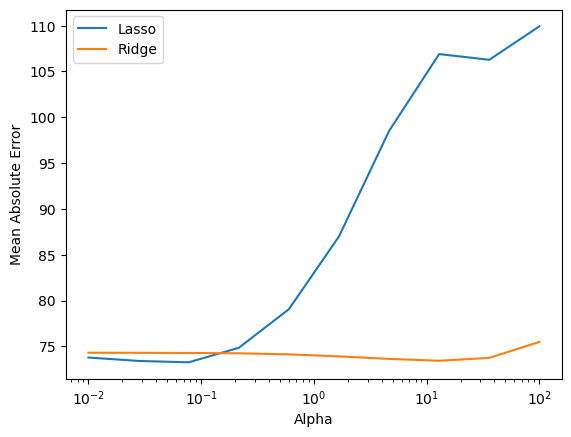

In [26]:
plt.semilogx(alphas, lasso_scores, label='Lasso')
plt.semilogx(alphas, ridge_scores, label='Ridge')
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

## regression tree

In [28]:
from sklearn.tree import DecisionTreeRegressor

In [122]:
model = DecisionTreeRegressor(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

print("Mean absolute error: {:.2f}".format(mae))

Mean absolute error: 63.04


In [125]:
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

In [131]:
feature_importances.head(15)

,feature,importance
0,accommodates,0.207961
18,bathrooms,0.129928
293,rt_Private room,0.075205
14,availability_365,0.035167
15,number_of_reviews,0.035148
247,pt_Entire serviced apartment,0.032981
280,pt_Room in hotel,0.032807
6,maximum_minimum_nights,0.030803
7,minimum_maximum_nights,0.027580
1,bedrooms,0.024934


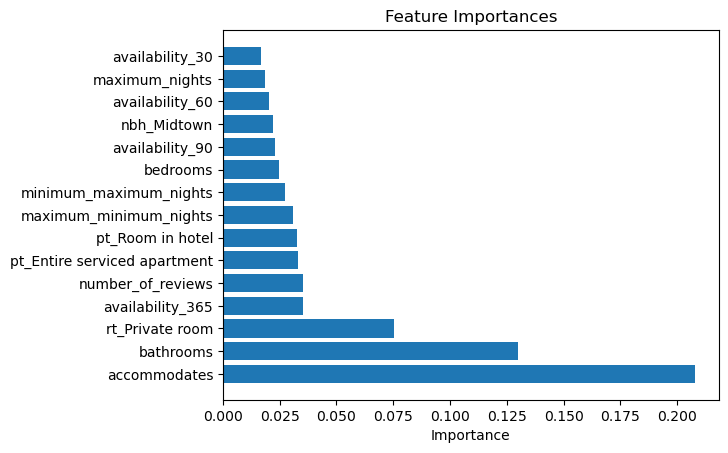

In [130]:
feature_importances = feature_importances.head(15)
plt.barh(feature_importances["feature"], feature_importances["importance"])
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.show()

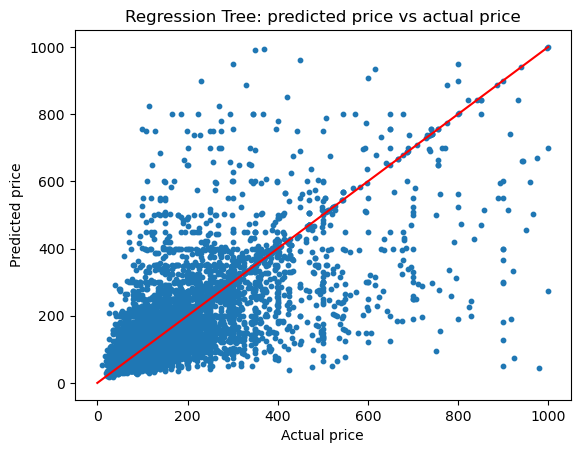

In [137]:
plt.scatter(y_test, y_pred, s= 10)
plt.title("Regression Tree: predicted price vs actual price")
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.plot([0, 1000], [0,1000], color='red') 
plt.show()

## sentiment analysis

In [10]:
reviews = pd.read_csv("reviews_2.csv")

In [11]:
listings = pd.read_csv("listings.csv")

In [12]:
pd.set_option('display.max_columns', None)

In [13]:
listings_df = listings[listings["number_of_reviews"]>=100][["id","review_scores_rating"]]

In [14]:
listings_df.isna().sum()

id                      0
review_scores_rating    0
dtype: int64

In [15]:
reviews_df = reviews[["listing_id","comments"]].dropna()
reviews_df.isna().sum()

listing_id    0
comments      0
dtype: int64

In [16]:
df = listings_df.sample(n=800,replace=False).merge(reviews_df, left_on="id",right_on="listing_id",how="inner")[["id","review_scores_rating","comments"]]

In [17]:
df

,id,review_scores_rating,comments
0,18872858,4.76,Great host.I checked in later than expected Ch...
1,18872858,4.76,Charles is a very accommodating host. The hous...
2,18872858,4.76,Very friendly host! We had everything we neede...
3,18872858,4.76,The place and the value are amazing for visiti...
4,18872858,4.76,"It is a great place really cozy, accessible to..."
...,...,...,...
148323,20960203,4.95,Lovely place to stay with fantastic hosts. I ...
148324,20960203,4.95,Tony’s place was wonderful and cozy. It was de...
148325,20960203,4.95,"Accurate photos, description, clean, Tony is v..."
148326,20960203,4.95,Great stay in a very quiet neighborhood. Very ...


In [18]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [19]:
df['comments'] = df['comments'].str.lower()
df['comments'] = df['comments'].str.replace('[^\w\s]','')
df['comments'] = df['comments'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [20]:
from langdetect import detect
from textblob import TextBlob

In [21]:
def get_sentiment_score(comment):
    blob = TextBlob(comment)
    return blob.sentiment.polarity

In [22]:
df['sentiment_score'] = df['comments'].apply(get_sentiment_score)

In [23]:
df = df[df['sentiment_score'] != 0]

In [47]:
pd.set_option('display.max_colwidth', None)

In [27]:
df["sentiment_score"].var()

0.042931317828053574

In [29]:
print(df["sentiment_score"].max(),df["sentiment_score"].min())

1.0 -1.0


In [64]:
df.loc[[55164,55125,55026,147941,148035,140223,46916,9017]][["comments","sentiment_score"]]

,comments,sentiment_score
55164,best place stay nyc,1.0
55125,excellent host recommend,1.0
55026,wonderful house area hosts five stars us,1.0
147941,great time thanks,0.5
148035,nice beds comfortable,0.5
140223,horrible,-1.0
46916,terrible stay,-1.0
9017,terrible,-1.0


In [65]:
df[df["id"] == 18872858][df["sentiment_score"] == 0.5]

,id,review_scores_rating,comments,sentiment_score
0,18872858,4.76,great hosti checked later expected charles great personcharles make stay wonderful experience,0.5
14,18872858,4.76,awesome owner accommodating apartment clean comfortable overall pleasant,0.5
24,18872858,4.76,one room top steep stairs noisey person,0.5
59,18872858,4.76,love staying charles place thats keep going back hes awesome host,0.5


In [68]:
df_agg = df.groupby('id').agg({'review_scores_rating': 'mean', 'sentiment_score': 'mean'})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_agg['sentiment_score'], df_agg['review_scores_rating'], test_size=0.3, random_state=42)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train.values.reshape(-1, 1), y_train)

LinearRegression()

In [70]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# Predict on the test set and calculate mean squared error
y_pred = model.predict(X_test.values.reshape(-1, 1))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
print('Mean squared error:', mse)
print("Mean absolute error:",mae)

Mean squared error: 0.023362883457676675
Mean absolute error: 0.12254433970071774


In [72]:
print(np.std(df_agg.review_scores_rating),df_agg.review_scores_rating.var())

0.16744502782629872 0.028072928504380423


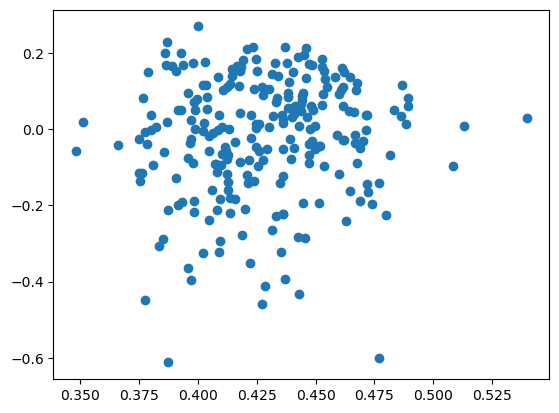

In [100]:
plt.scatter(X_test,y_test-y_pred)

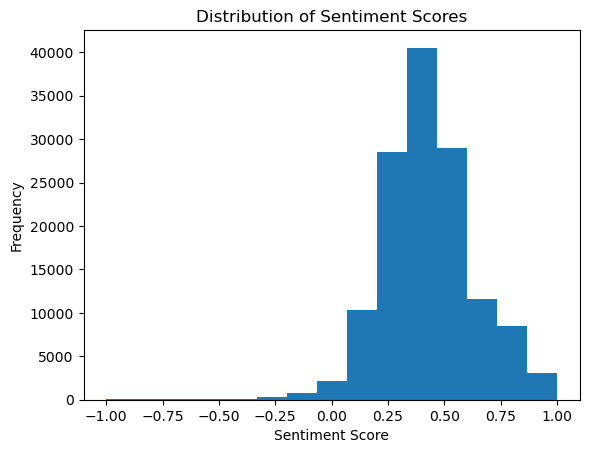

In [108]:
plt.hist(df['sentiment_score'], bins=15)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()

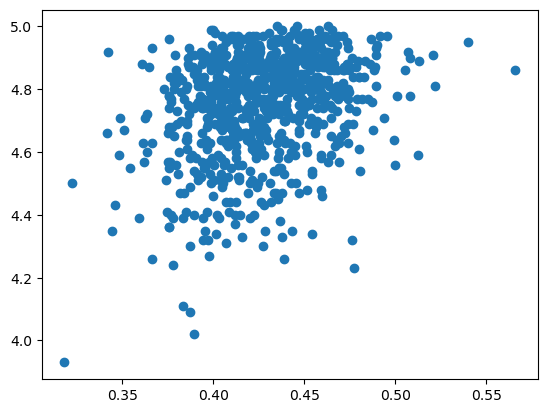

In [107]:
plt.scatter(df_agg["sentiment_score"],df_agg["review_scores_rating"])